In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data = pd.read_csv('AAPL.csv', header=0, usecols=['Date', 'Close'], parse_dates=True, index_col= 'Date')

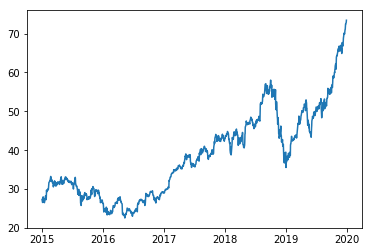

In [3]:
plt.plot(data['Close'])
plt.show()

In [4]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [5]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [6]:
# 70-30 split
train_length = int(len(scaled_data) * 0.7)
test_length = len(scaled_data) - train_length
train_data = scaled_data[0:train_length,:]
test_data = scaled_data[train_length:len(scaled_data),:]

In [7]:
def create_dataset(dataset, timestep = 1):
    data_x, data_y = [], []
    for i in range(len(dataset) - timestep - 1):
        data_x.append(dataset[i: (i+timestep), 0])
        data_y.append(dataset[i + timestep, 0])
    return np.array(data_x), np.array(data_y)

In [8]:
timestep = 1
train_x, train_y = create_dataset(train_data, timestep)
test_x, test_y = create_dataset(test_data, timestep)

In [9]:
train_x = np.reshape(train_x, (train_x.shape[0], 1, train_x.shape[1]))
test_x = np.reshape(test_x, (test_x.shape[0], 1, test_x.shape[1]))

In [10]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

In [13]:
model = Sequential()

# Adding the first LSTM layer
model.add(LSTM(units = 50, return_sequences = True, input_shape = (train_x.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 50, return_sequences = True))
    
# Adding a third LSTM layer
model.add(LSTM(units = 50, return_sequences = True))

# Adding a fourth LSTM layer
model.add(LSTM(units = 50))

# Adding the output layer
model.add(Dense(units = 1))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 50)             10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             20200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 71,051
Trainable params: 71,051
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(train_x, train_y, epochs=1, batch_size=1, verbose=1)
score = model.evaluate(train_x, train_y, verbose=0)
print('Keras model loss = ', score[0])
print('Keras model accuracy = ', score[1])

878/878 [==============================] - 3s 3ms/step - loss: 1.7548e-04 - accuracy: 0.0011
Keras model loss =  0.00021944951731711626
Keras model accuracy =  0.0011389522114768624


In [19]:
train_predictions = model.predict(train_x)
test_predictions = model.predict(test_x)


In [20]:
train_predictions = scaler.inverse_transform(train_predictions)
train_y = scaler.inverse_transform([train_y])

test_predictions = scaler.inverse_transform(test_predictions)
test_y = scaler.inverse_transform([test_y])

In [21]:
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:,:] = np.nan
train_predict_plot[1:len(train_predictions)+1, :] = train_predictions

In [22]:
test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predictions)+2+1 : len(scaled_data)-1, :] = test_predictions

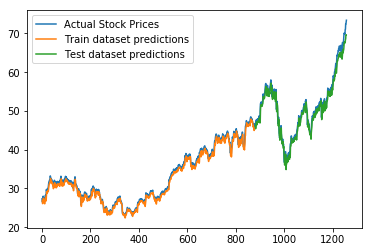

In [23]:
actual_stock_prices, = plt.plot(scaler.inverse_transform(scaled_data), label='Actual Stock Prices')
train_dataset_prediction, = plt.plot(train_predict_plot, label='Train dataset predictions')
test_dataset_prediction, = plt.plot(test_predict_plot, label='Test dataset predictions')
plt.legend(handles = [actual_stock_prices, train_dataset_prediction, test_dataset_prediction])
plt.show()

In [25]:
data1 = pd.read_csv('AAPL.csv')
test_data_list = data1['Close'].tolist()
test_data_sliced = test_data_list[int(len(test_data_list)*0.7+2):int(len(test_data_list))]
test_data_array = np.array(test_data_sliced)

test_prediction_flattened = test_predictions.flatten()

df = pd.DataFrame({'Actual Values':test_data_array, 'Predicted Values':test_prediction_flattened})


error = mean_squared_error(test_data_array, test_prediction_flattened)
print('Testing Mean Squared Error: %.3f' % error)

Testing Mean Squared Error: 2.590


In [26]:
df

,Actual Values,Predicted Values
0,46.349998,46.224522
1,46.992500,45.404682
2,47.645000,45.777103
3,47.587502,46.422916
4,46.970001,47.077480
5,47.757500,47.019855
6,47.832500,46.400322
7,47.727501,47.190189
8,47.862499,47.265308
9,47.599998,47.160141
